In [43]:
import pandas as pd
import numpy as np
import itertools
import random
import seaborn as sns
import pickle
from mpl_toolkits.mplot3d import Axes3D  # Necessario per i plot 3D


from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, silhouette_samples, silhouette_score

from sklearn.model_selection import learning_curve, validation_curve, train_test_split
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.datasets import fetch_openml

from scipy.stats import loguniform, beta, uniform

import missingno as msno

import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# warnings.filterwarnings('ignore')



I'm using the "marketing_campaign" dataset from Kaggle, also known as "Customer Personality Analysis". This dataset is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer Personality Analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

Key Objectives are:
1)**Explore the data** - don’t just plot means and counts. Provide insights, define cause and effect. Provide a better understanding of the characteristic features of respondents;
2)**Propose and describe** a customer segmentation based on customers behaviors;
3)Create a **predictive model** which allows the company to maximize the profit of the next marketing campaign.

Data are represented as tabular data, each row is a customer and each column is a feature describing the customer.

We load the dataset thorugh the <code>read_csv</code> method in Panda. In this case, the file uses a tab character (\t) as the separator between columns instead of the default comma (,). This is common in TSV (Tab-Separated Values) files. Hence we need to specify the delimiter  <code>delimiter='\t'</code> in the <code>read_csv</code> method.

In [2]:

df = pd.read_csv('cannabis_strains_data_1000.csv', delimiter='\t')  # Load the dataset using pandas

# Displaying basic information about the DataFrame to confirm successful loading
df


,"Nome varietà,""Tipo (Sativa, Indica, Ibrida, Ruderalis)"",Genetica/Origine,THC (%),CBD (%),Effetti prevalenti,Aromi e sapori,Tempo fioritura (giorni),Altezza media (cm),Resa indoor (g/m²),Difficoltà coltivazione,Uso terapeutico,Note aggiuntive"
0,"White Widow,N/A,N/A,15,N/A,N/A,N/A,N/A,N/A,N/A..."
1,"OG Kush,N/A,N/A,25,0,N/A,N/A,N/A,N/A,N/A,N/A,N..."
2,"Blue Dream,N/A,N/A,21,0,N/A,N/A,N/A,N/A,N/A,N/..."
3,"Girl Scout Cookies,N/A,N/A,25,N/A,N/A,N/A,N/A,..."
4,"Northern Lights,N/A,N/A,18,N/A,N/A,N/A,N/A,N/A..."
...,...
995,"Electric Candy,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A..."
996,"Chilean Runtz x Animal Cookies,N/A,N/A,N/A,N/A..."
997,"Amsterdam Frost,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/..."
998,"Zkittlez OG #67,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/..."


There are 2240 rows and 29 columns in the dataset:
    -"Income" is the only numerical feature of float64 type.
    -"Education", "Marital_Status" and "Dt_Customer" are the only categorical features of object type.
**Description of the Attributes**:
![](dictionary.png) 

In [3]:
#We convert the "Dt_Customer" column to datetime format
df['Dt_Customer'] = pd.to_datetime(df.Dt_Customer, format="%d-%m-%Y")
df.Dt_Customer.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2240 entries, 0 to 2239
Series name: Dt_Customer
Non-Null Count  Dtype         
--------------  -----         
2240 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.6 KB


# Data Cleaning

### Missing Values

Before the training and test splitting, we have to deal with missing value. Specifically, we have to define the strategy to apply after the splitting if we encounter missing values.

We can compute the percentage of missing values in the dataset and see which features are more problematic: 
We use the <code>isnull</code> method that returns TRUE if we have a missing value on the matrix. The <code>sum(axis=0)</code> method is used to compute the sum on the row axis, giving us the number of missing values per column. We then divide this number by the number of rows, given by the <code>shape</code> method, to obtain the percentage.

In [4]:
df.isnull().sum(axis=0)/df.shape[0] # Calculate the percentage of missing values

ID                     0.000000
Year_Birth             0.000000
Education              0.000000
Marital_Status         0.000000
Income                 0.010714
Kidhome                0.000000
Teenhome               0.000000
Dt_Customer            0.000000
Recency                0.000000
MntWines               0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts        0.000000
MntSweetProducts       0.000000
MntGoldProds           0.000000
NumDealsPurchases      0.000000
NumWebPurchases        0.000000
NumCatalogPurchases    0.000000
NumStorePurchases      0.000000
NumWebVisitsMonth      0.000000
AcceptedCmp3           0.000000
AcceptedCmp4           0.000000
AcceptedCmp5           0.000000
AcceptedCmp1           0.000000
AcceptedCmp2           0.000000
Complain               0.000000
Z_CostContact          0.000000
Z_Revenue              0.000000
Response               0.000000
dtype: float64

In [5]:
# Remove unnecessary columns 
# We do not have a description for zcostcontact and zrevenue and we don't need ID
df.drop(["ID","Z_CostContact","Z_Revenue"],axis=1,inplace=True)

An intuitive visualization tool supportin the analysis of missing values - besides Pandas' methods or DataFrame visualization - is the library <code>missingno</code>. In particular, via the <code>matrix</code> method we can plot where the missing values are located in the feature matrix.

<AxesSubplot: >

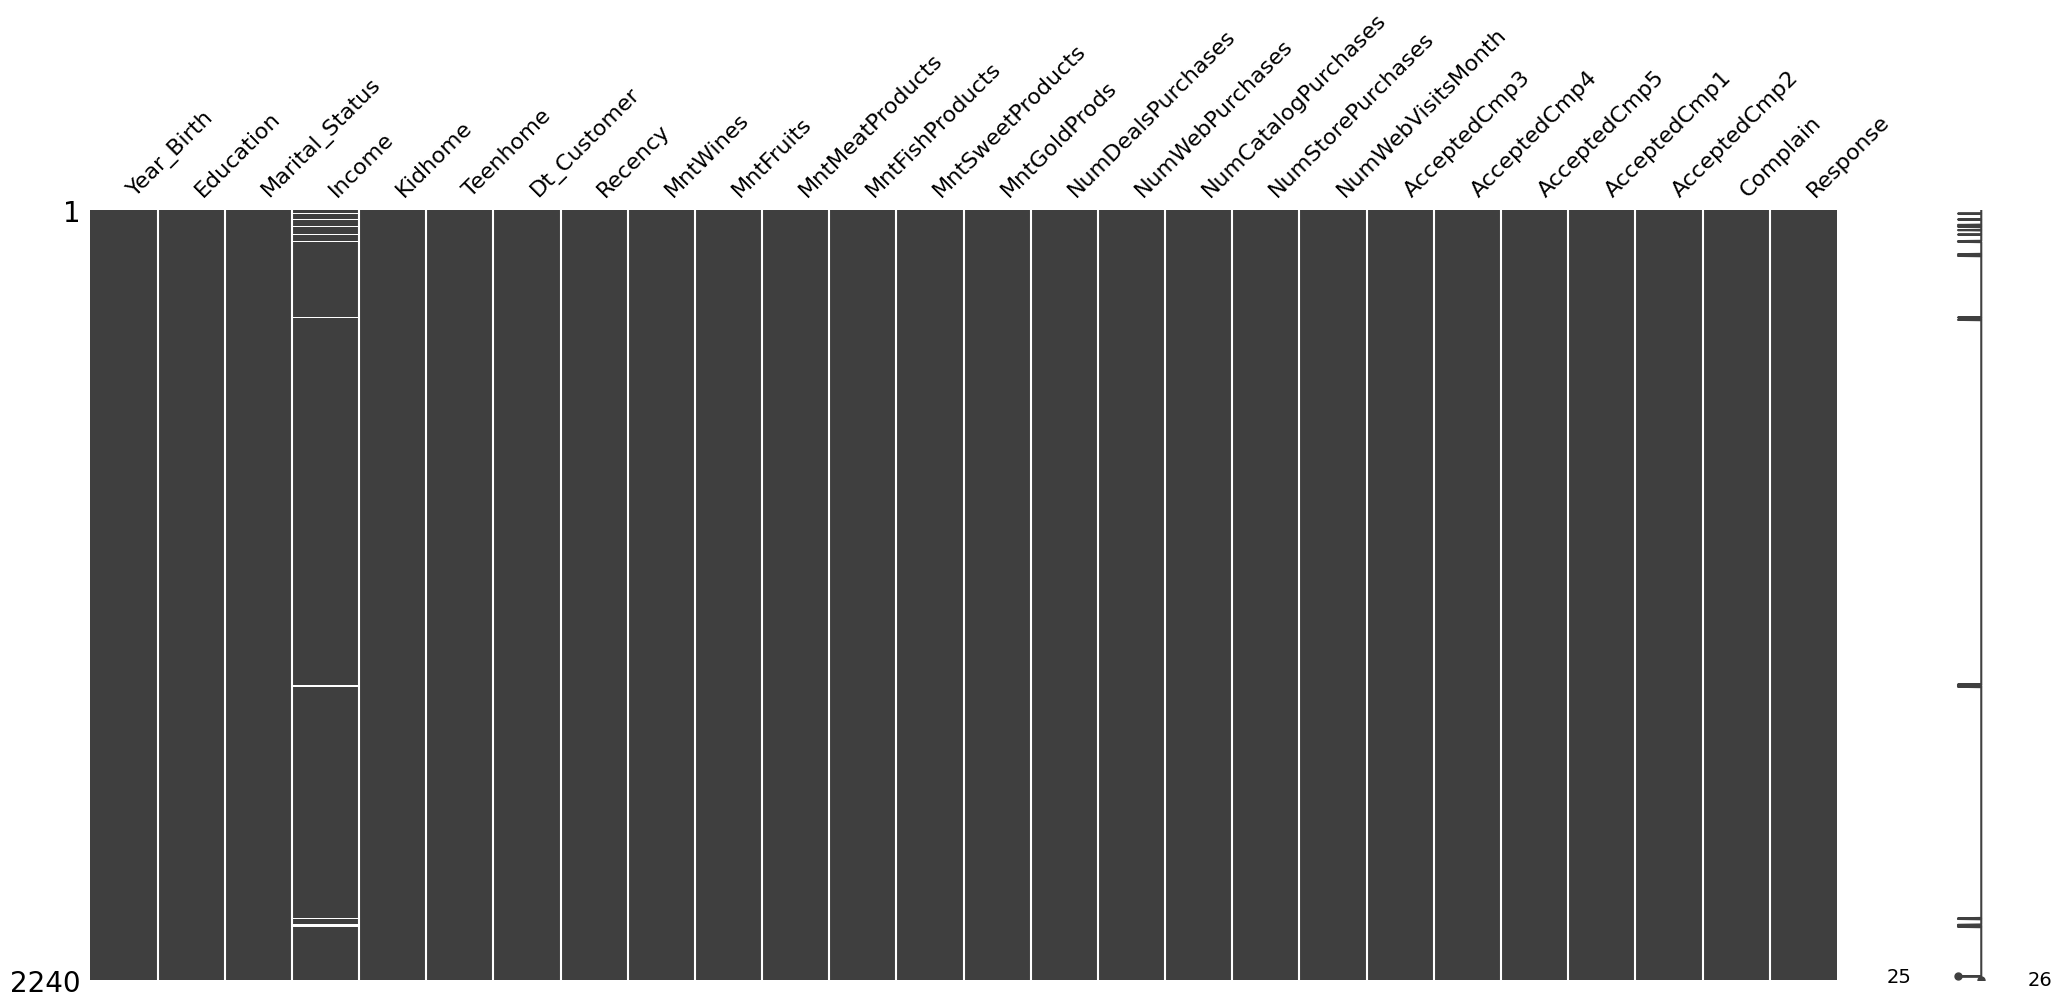

In [6]:
msno.matrix(df)

We can now crearly see that **Income** is the only feature that contains missing values.
Due to the fact that only 1% of the data is missing, we can then proceed to remove the rows with missing values.

In [7]:
# Drop the null values
df=df.dropna()
print(f"Missing values in data: {df.isnull().sum().sum()}")
print(f"There are now : {df.shape[0]} rows and : {df.shape[1]} columns")

Missing values in data: 0
There are now : 2216 rows and : 26 columns


### Incongruences

1. Check for customers that didn't buy anything but still have a value >0 in the number of purchases made with a discount.

In [8]:
# Filter rows where 'NumDealsPurchases' > 0 but no purchases were made (all other purchase columns are 0)
condition= df[(df['NumDealsPurchases'] > 0) & (df['NumWebPurchases'] == 0) & (df['NumCatalogPurchases'] == 0) & (df['NumStorePurchases'] == 0)]

# Show the resulting DataFrame
condition


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
1245,1971,Graduation,Divorced,1730.0,0,0,2014-05-18,65,1,1,...,0,0,20,0,0,0,0,0,0,0
1846,1963,PhD,Married,4023.0,1,1,2014-06-23,29,5,0,...,0,0,19,0,0,0,0,0,0,0


Since **NumDealsPurchases** are the total number of purchases made with discount applied irrespective of the platform of the purchase and here we notice that no purchases were made by these customers, we assume that these infos are wrong and we can remove them.


In [9]:
# Create the condition as a boolean mask, not a subsetted DataFrame, to use the ~ to negate the condition
condition = (df['NumDealsPurchases'] > 0) & (df['NumWebPurchases'] == 0) & (df['NumCatalogPurchases'] == 0) & (df['NumStorePurchases'] == 0)
df = df[~condition]

# Resetting the index ensures that the index of the DataFrame is sequential after the rows are removed.
df.reset_index(drop=True, inplace=True)

# Double-check for any remaining rows that meet the condition (should return an empty DataFrame)
print(df[(df['NumDealsPurchases'] > 0) & (df['NumWebPurchases'] == 0) & (df['NumCatalogPurchases'] == 0) & (df['NumStorePurchases'] == 0)])


Empty DataFrame
Columns: [Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Response]
Index: []

[0 rows x 26 columns]


**Recency** column means "Number of days since customer's last purchase". 
2. Check if the customer didn't purchase anything and still has a value in the **Recency** column.


In [10]:
# # Calculate the total purchases for each customer by summing relevant columns
df['Total_Purchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# Filter the DataFrame to only include customers with Total_Purchases = 0 and Recency > 0
condition_2 = df[(df['Total_Purchases'] == 0) & (df['Recency'] > 0)]

# Show the resulting DataFrame
condition_2

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_Purchases
642,1975,Graduation,Divorced,153924.0,0,0,2014-02-07,81,1,1,...,0,0,0,0,0,0,0,0,0,0
968,1965,Graduation,Divorced,4861.0,0,0,2014-06-22,20,2,1,...,0,14,0,0,0,0,0,0,0,0
1506,1973,Graduation,Single,3502.0,1,0,2013-04-13,56,2,1,...,0,14,0,0,0,0,0,0,0,0
2107,1949,PhD,Married,156924.0,0,0,2013-08-29,85,2,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Drop the rows where Total_Purchases = 0 and Recency > 0
condition_2 = (df['Total_Purchases'] == 0) & (df['Recency'] > 0)
df = df[~condition_2]  # Filter rows by negating the condition

# Reset the index
df.reset_index(drop=True, inplace=True)

# Double-check on the updated DataFrame
print(df[(df['Total_Purchases'] == 0) & (df['Recency'] > 0)])

Empty DataFrame
Columns: [Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Response, Total_Purchases]
Index: []

[0 rows x 27 columns]


3. Check if the customer didn't buy anything (**Total_purchases** == 0)  but still has spent some money in at least one of the five selling products (**MntWines**, **MntFruits**, ecc.).

In [12]:
# Identifica righe con Total_Purchases == 0 ma spese > 0
condition_3 = df[(df['Total_Purchases'] == 0) & (
    (df['MntWines'] > 0) | (df['MntFruits'] > 0) | (df['MntMeatProducts'] > 0) |
    (df['MntFishProducts'] > 0) | (df['MntSweetProducts'] > 0) | (df['MntGoldProds'] > 0)
)]
# Show the resulting DataFrame
condition_3

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_Purchases


4. Check if the customer's recency is greater than the customer's enrollment date. 

In [13]:
# # Calcola i giorni dall'iscrizione
df['Days_Since_Enrollment'] = (pd.Timestamp.today() - pd.to_datetime(df['Dt_Customer'], errors='coerce')).dt.days

# Verifica se Recency è maggiore dei giorni dall'iscrizione
condition_4 = df['Recency'] > df['Days_Since_Enrollment']

# Mostra le righe problematiche
df[condition_4]


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_Purchases,Days_Since_Enrollment


In [14]:
# Count the number of columns for each data type
col_types = df.dtypes.value_counts()
print("Number of columns for each data type:")
print(col_types)
print("Number of rows:", df.shape[0])

Number of columns for each data type:
int64             24
object             2
float64            1
datetime64[ns]     1
Name: count, dtype: int64
Number of rows: 2210


Now we know that data is clean, there are no missing values in the dataset and that most of the columns are Numerical features.
The only Categorical features are: "Education", "Marital_Status" and "Dt_Customer".

In [15]:
df

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_Purchases,Days_Since_Enrollment
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,7,0,0,0,0,0,0,1,22,4549
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,5,0,0,0,0,0,0,0,4,3999
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,4,0,0,0,0,0,0,0,20,4198
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,6,0,0,0,0,0,0,0,6,4025
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,0,0,0,0,0,0,0,14,4047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,...,5,0,0,0,0,0,0,0,16,4267
2206,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,...,7,0,0,0,1,0,0,0,15,3905
2207,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,...,6,0,1,0,0,0,0,0,18,4041
2208,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,...,3,0,0,0,0,0,0,0,21,4042


# Explore Data

Let's delve into the age distribution of the customers:

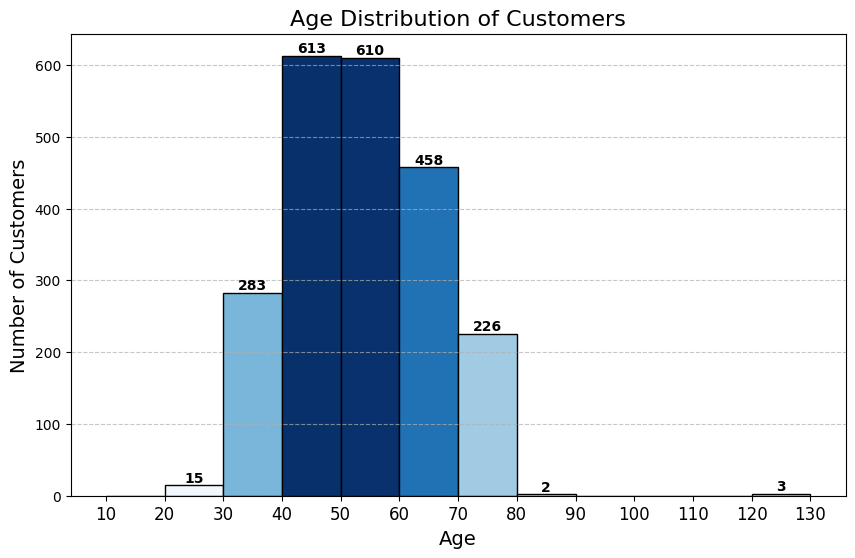

In [16]:
df['Age'] = 2022 - df['Year_Birth'] #dataset is 3 years old
# Define bins for 10-year intervals
bins = range(10, int(df['Age'].max()) + 10, 10)

# Plot the age distribution
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df['Age'], bins=bins, color='skyblue', edgecolor='black')
for i in range(len(patches)):
    patches[i].set_facecolor(sns.color_palette("Blues", as_cmap=True)(n[i] / max(n)))
    if n[i] > 0:
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], int(n[i]), 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.title('Age Distribution of Customers', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
# Adjust the x-axis ticks to show the bins clearly
plt.xticks(bins, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Customer Age group breakdown:

 **20-30**: 15 customers, indicating a small segment of young adults.
 **30-40**: 283 customers, a growing segment representing younger adults with potential for long-term engagement. 
 **40-50**: 613 customers,the largest group, indicating the core demographic is middle-aged.
 **50-60**: 610 customers, the core together with the 40-50 age group.
 **60-70**: 458 customers, showing strong representation in older adulthood and also a decreasing segment.
 **70-80**: 226 customers, indicating a steady trend in the senior category, which continuously decreases.
 **80+**: 2+3 customers, a very small segment of very elderly customers.

## Key Insights:

**Core Demographic (40-60)**: This age group forms the largest customer base, suggesting that products/services might appeal most to middle-aged individuals.
**Declining Trend with Age (60+)**: As age increases beyond 60, the number of customers gradually decreases, indicating less engagement among older seniors.
**Potential Growth Areas**: The 30-40 age group could be nurtured for long-term loyalty, as they may have different needs and preferences. Also the 20-30 age group could be considered to include more customers.
**Senior Presence**: While numbers decrease with age, there is still a notable segment in the 60-80 range, suggesting that targeted offerings for senior customers could be beneficial.
**Outliers**: There are very few customers above 90, possibly indicating limited engagement from extremely elderly individuals.

Let's check the education distribution of the customers:

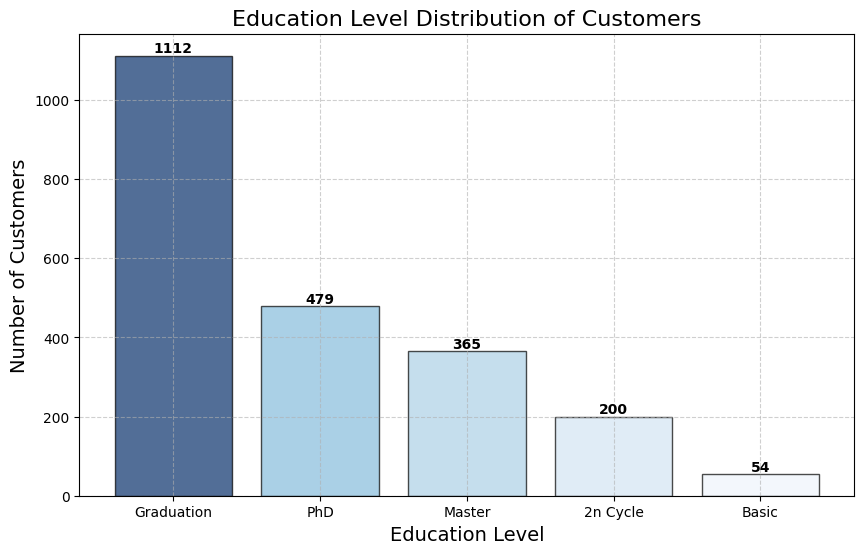

In [17]:
plt.figure(figsize=(10, 6))
# Count occurrences of each education level
education_counts = df['Education'].value_counts()
# Normalize color by the bar height
bars = plt.bar(education_counts.index, education_counts.values, color='blue', alpha=0.7, edgecolor='black')
for i, bar in enumerate(bars):
    bar.set_facecolor(sns.color_palette("Blues", as_cmap=True)(education_counts.values[i] / max(education_counts.values)))
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Education Level Distribution of Customers', fontsize=16)
plt.xlabel('Education Level', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Customers Education Levels Breakdown:

**Graduation**: 1112 customers, forming the largest group, indicating a high level of educational attainment.
**PhD**: 479 customers, a significant segment with advanced academic qualifications.
**Master**: 365 customers, making up a considerable portion of the customer base with postgraduate education.
**2nd Cycle**: 200 customers, representing individuals with some higher education but possibly not a completed degree.
**Basic**: 54 customers, a smaller group with basic education levels.


## Key Insights:

**Higher Education**: The majority of customers have attained at least a graduate level of education, indicating that the customer base is highly educated.
**Lower Levels**: A much smaller percentage of customers have only a basic education, suggesting a market with a predominantly higher-educated demographic.
**Targeting Potential**: Strategies can be tailored to appeal to customers with higher education backgrounds, as they form the majority.

Let's check the distribution of customers by marital status:

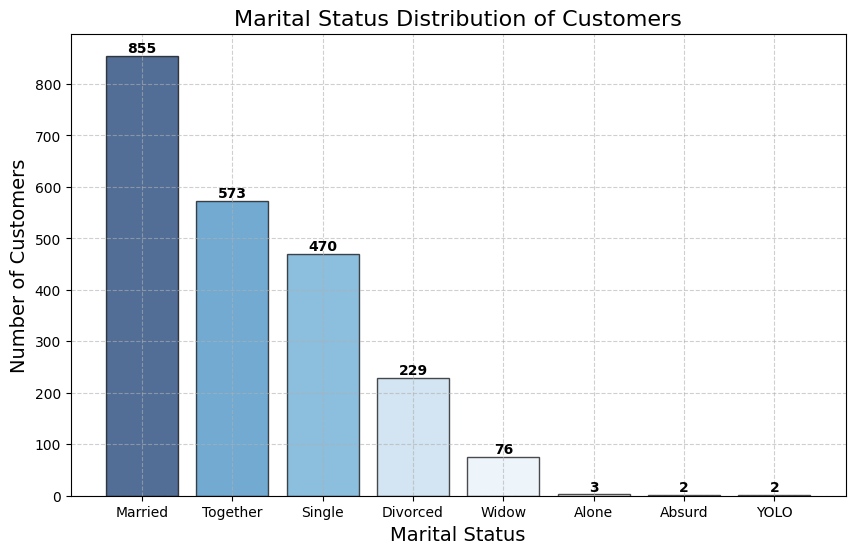

In [18]:
# Create a figure for the Marital_Status plot
plt.figure(figsize=(10, 6))

# Marital status distribution
marital_counts = df['Marital_Status'].value_counts()
bars_marital = plt.bar(marital_counts.index, marital_counts.values, color='blue', alpha=0.7, edgecolor='black')

# Apply the same color palette from 'Education' to 'Marital_Status'
for i, bar in enumerate(bars_marital):
    bar.set_facecolor(sns.color_palette("Blues", as_cmap=True)(marital_counts.values[i] / max(marital_counts.values)))
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Marital Status Distribution of Customers', fontsize=16)
plt.xlabel('Marital Status', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Customers Marital Status breakdown:

**Married**: 855 customers, representing the largest group, indicating a substantial customer base of married individuals.
**Together**: 573 customers, a significant segment who are in relationships.
**Single**: 470 customers, making up a notable part of the customer base.
**Divorced**: 229 customers, showing a moderate presence of divorced individuals.
**Widow**: 76 customers, a smaller but still relevant group.
**Alone, Absurd and YOLO**: 3+2+2 customers, a very small segment of customers, representing unique entries.

## Key Insights

**Married and Together**: These two categories form the majority, possibly indicating a preference for products/services appealing to partnered individuals.
**Single and Divorced**: Although smaller in number, they still represent a considerable segment that could be targeted with specific marketing strategies.
**Outliers**: Categories like "Absurd" and "YOLO" may need review for data quality or validation purposes.

Let's check the distribution of customers by their income:

/root/venv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 66.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


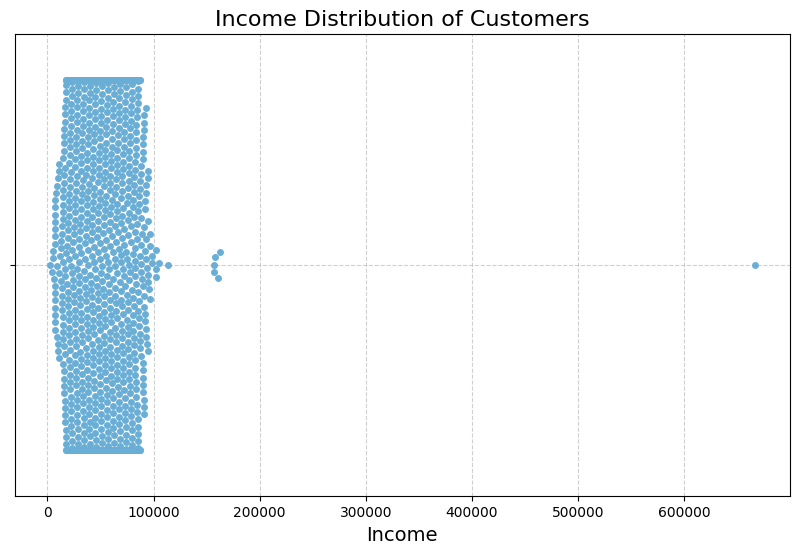

In [19]:
# Create a figure for the Income swarm plot
plt.figure(figsize=(10, 6))

# Swarm plot for Income distribution
sns.swarmplot(x=df['Income'], color=sns.color_palette("Blues", 1)[0])

# Adding title and labels
plt.title('Income Distribution of Customers', fontsize=16)
plt.xlabel('Income', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## Customers Income breakdown:

**0-100,000**: Majority of customers, representing moderate incomes.
**100,000 - 200,000**: Small higher-income segment.
**Outlier**: One customer with income over 600,000.

## Key Insights:

**Core Group**: Customers with incomes under 100,000 are the largest demographic.
**Higher-Income Potential**: Small representation from high-income customers suggests room for growth.
**Extreme Outlier**: The high-income outlier could offer unique insights.

Let's check the distribution of the Kids and Teens at home.

To do so, we need to create a new feature to know if the customer is a parent or not.

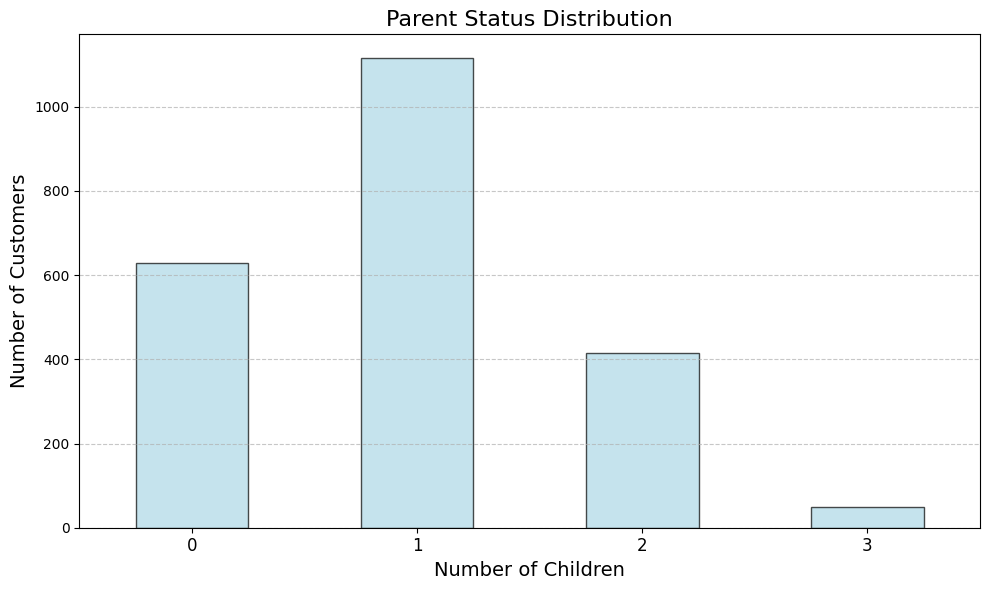

In [20]:
# Create a new feature 'is_Parent' where value is equal to the number of children
df['is_Parent'] = df['Kidhome'] + df['Teenhome']

# Count occurrences of the 'is_Parent' feature for visualization
parent_counts = df['is_Parent'].value_counts().sort_index()

# Plot the distribution of the 'is_Parent' feature
plt.figure(figsize=(10, 6))
parent_counts.plot(kind='bar', color='lightblue', edgecolor='black', alpha=0.7, width=0.5)

# Add title and labels
plt.title('Parent Status Distribution', fontsize=16)
plt.xlabel('Number of Children', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)

# Labels equal to the number of children
plt.xticks(ticks=range(len(parent_counts.index)), labels=parent_counts.index, fontsize=12, rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Children at Home breakdown:

**0**: Valid representation of customers with no children at home.
**1**: Majority of customers representing those with one child at home.
**2**: Smaller than **0** but still relevant representation of customers with two children at home.
**3**: Small representation of customers with three or more children at home.

## Key Insights:

**Core Group**: Customers that only have 1 child are the largest demographic (1000+).
**Potential Growth**: The representations of those with no children or with more than one at home are still relevant (600+ and 400+) and could offer room for growth.

Let's check the distribution of accepted campaigns by the customers.

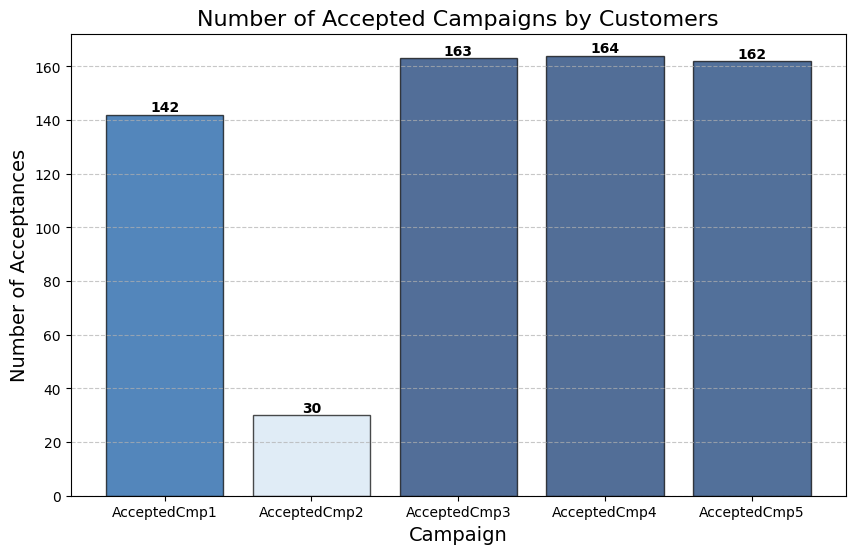

In [21]:
# Aggregate accepted campaigns data
accepted_campaigns_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
accepted_counts = df[accepted_campaigns_columns].sum()

# Plot the distribution
plt.figure(figsize=(10, 6))

bars_cmp = plt.bar(accepted_counts.index, accepted_counts.values, color='blue', alpha=0.7, edgecolor='black')
# Apply the same color palette from 'Education' to 'Marital_Status'
for i, bar in enumerate(bars_cmp):
    bar.set_facecolor(sns.color_palette("Blues", as_cmap=True)(accepted_counts.values[i] / max(accepted_counts.values)))
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add title and labels
plt.title('Number of Accepted Campaigns by Customers', fontsize=16)
plt.xlabel('Campaign', fontsize=14)
plt.ylabel('Number of Acceptances', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

## Accepted Campaigns breakdown:

**AcceptedCmp3, 4 , 5**: Almost similar number of acceptances for each campaign, representing the majority of customers and indicating High engagement for these 3 campaigns.
**AcceptedCmp1**: Less engagement than the other 3 campaigns but still relevant.
**AcceptedCmp2**: Smaller segment with low engagement.

## Key Insights:

**Top Campaigns**: The most successful campaigns are 3, 4 and 5, indicating high engagement by customers and their effectiveness.
**Bottom Campaigns**: The least successful campaigns are 1 and 2, indicating low engagement by customers, possibly due to reduced appeal or effectiveness.

Let's check the distribution of the amount spent in each category.

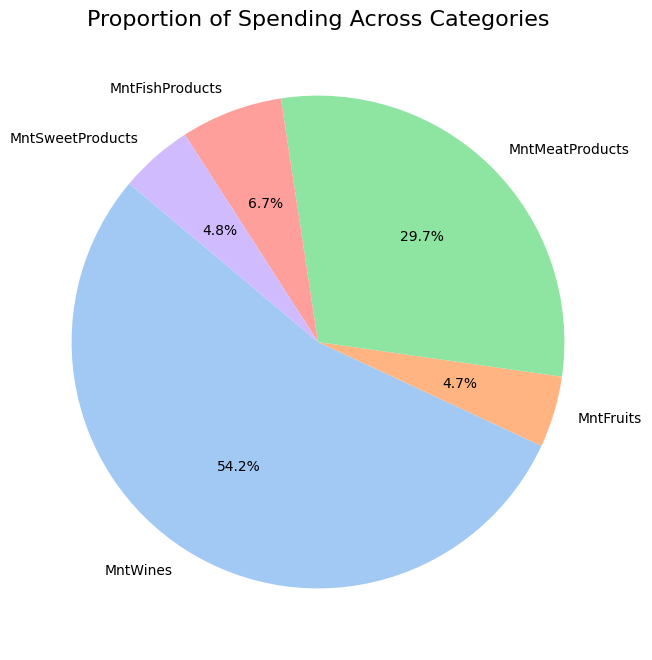

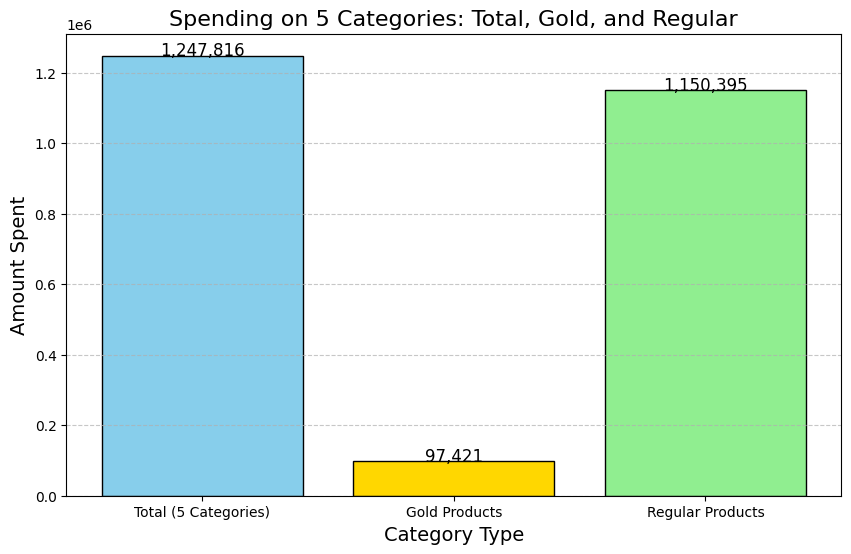

The percentage of gold products is 7.807320951165877
Total amount: 1247816
Total spent on gold products: 97421
Meaning that the amount spent on regular products is 1150395


In [22]:
# List of product categories
product_categories = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']

# Calculate the total amount spent on each category
total_spent = df[product_categories].sum()
#Compute the percentage of gold products
total_gold = df["MntGoldProds"].sum()
perc_gold = total_gold / total_spent.sum() *100
total_regular = total_spent.sum() - total_gold


# Plot a pie chart
plt.figure(figsize=(8, 8))
total_spent.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Proportion of Spending Across Categories', fontsize=16)
plt.ylabel('')  # Remove default ylabel
plt.show()

# Data for the bar chart
categories = ['Total (5 Categories)', 'Gold Products', 'Regular Products']
values = [total_spent.sum(), total_gold, total_regular]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['skyblue', 'gold', 'lightgreen'], edgecolor='black')
plt.title('Spending on 5 Categories: Total, Gold, and Regular', fontsize=16)
plt.xlabel('Category Type', fontsize=14)
plt.ylabel('Amount Spent', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 100, f'{value:,.0f}', ha='center', fontsize=12)

plt.show()
print("The percentage of gold products is", perc_gold)
print("Total amount:", total_spent.sum() )
print("Total spent on gold products:", df["MntGoldProds"].sum() )
print("Meaning that the amount spent on regular products is", total_spent.sum() - df["MntGoldProds"].sum())




## Products amount breakdown:

**MntWines**: More than half of the total amount (54.2%) is spent on wines.
**MntMeatProducts**: 29.7% is spent on meat products, representing the second most popular category.
**Other categories**: 4.7% is spent on **MntFruits**, 4.8% on **MntSweetProducts** and 6.7% on **MntFishProducts**. These catetegories represent the least popular products, amounting to only the 16,2% of the total.
**Premium Products**: The amount of premium products bought by customers is only 7.8% of the total. 

## Key insights:

**Core Spending Category**: Wine products make up over half of the total spending, indicating a strong preference or demand for this product category among customers.
**Lower Spending Categories**: Fruits, Sweets and Fish account for the smallest portions of spending, possibly indicating less demand for these items.
**Potential Growth Areas**: Meat products represents a significant part of spending, so promotions or targeted campaigns in this area could be effective.
**Customer Prefernces**: It seems that customers prefer to spend more in regular products (91.2% of the total) than in gold products (7.8%), suggesting a preference for lower prices.

Let's check the distribution of Purchases and Web visits made by customers:

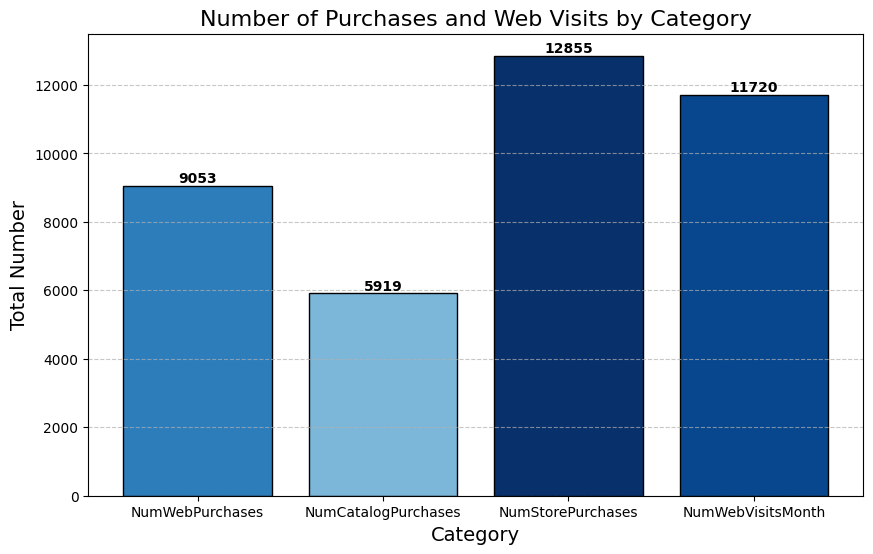

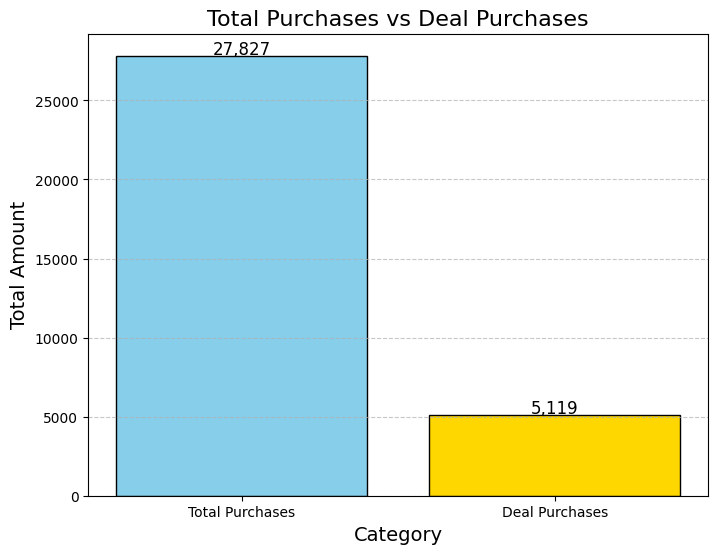

Percentage of store purchases: 46.19614043914184 i.e.  12855 / 27827
Percentage of web purchases: 32.53315125597441 i.e.  9053 / 27827
Percentage of catalog purchases: 21.270708304883744 i.e.  5919 / 27827
Percentage of deal purchases: 18.39580263772595 i.e.  5119 / 27827


In [23]:
# Columns for the categories
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']


# Compute totals for each category
totals = df[purchase_columns].sum()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars_purch = plt.bar(purchase_columns, totals, color='lightblue', edgecolor='black')
plt.title('Number of Purchases and Web Visits by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Total Number', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars
for i, bar in enumerate(bars_purch):
    bar.set_facecolor(sns.color_palette("Blues", as_cmap=True)(totals.values[i] / max(totals.values)))
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')


# Define columns for total purchases
purchase_columns = ['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases']

# Compute the total purchases and deal purchases
total_purchases = df[purchase_columns].sum().sum()  # Sum across the three columns
total_deal_purchases = df['NumDealsPurchases'].sum()

# Prepare data for the bar chart
categories = ['Total Purchases', 'Deal Purchases']
values = [total_purchases, total_deal_purchases]

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'gold'], edgecolor='black')
plt.title('Total Purchases vs Deal Purchases', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Total Amount', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 100, f'{value:,.0f}', ha='center', fontsize=12)

plt.show()

store_percentages = df["NumStorePurchases"].sum() / total_purchases *100
web_percentages = df["NumWebPurchases"].sum() / total_purchases *100
catalog_percentages = df["NumCatalogPurchases"].sum() / total_purchases *100
deals_percentages = df["NumDealsPurchases"].sum() / total_purchases *100
print("Percentage of store purchases:", store_percentages, "i.e. ",df["NumStorePurchases"].sum(),"/",total_purchases)
print("Percentage of web purchases:", web_percentages, "i.e. ",df["NumWebPurchases"].sum(),"/",total_purchases)
print("Percentage of catalog purchases:", catalog_percentages, "i.e. ",df["NumCatalogPurchases"].sum(),"/",total_purchases)
print("Percentage of deal purchases:", deals_percentages, "i.e. ",df["NumDealsPurchases"].sum(),"/",total_purchases)

## Purchases and Web visits breakdown:

**NumStorePurchases**: The majority of purchases are made through the store (46%).
**NumWebPurchases**: A less representative portion of purchases are made through the web (33%).
**NumCatalogPurchases**: The least representative portion of purchases are made through the catalog (21%).
**NumWebVisitsMonth**: Shows the proportion of web visits each month, suggesting strong online engagement and browsing interest.
**NumDealsPurchases**: A small portion of purchases are made through deals (18%).
Recall: **NumDealsPurchases** are the total number of purchases made with discount applied irrespective of the platform of the purchase.

## Key Insights:

**Store Purchases Dominance**: Physical store purchases hold the highest share, suggesting a preference for in-store shopping among customers.
**Web Visits vs. Online Purchases**: High web visit rates indicate online engagement, but the gap with web purchases suggests room to improve online conversion rates.
**Deals**: A small portion of purchases is from deals, possibly showing that customers are less influenced by discounts, or that fewer promotional deals are available.

Let's check how many customers have complained:

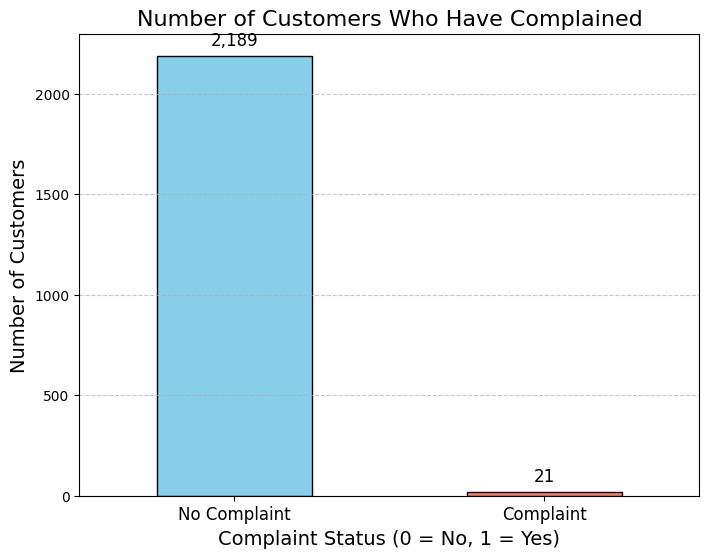

In [24]:
# Count the number of customers who have complained and not complained
complaint_counts = df['Complain'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
complaint_counts.plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.title('Number of Customers Who Have Complained', fontsize=16)
plt.xlabel('Complaint Status (0 = No, 1 = Yes)', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks([0, 1], labels=['No Complaint', 'Complaint'], rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of the bars
for i, count in enumerate(complaint_counts):
    plt.text(i, count + 50, f'{count:,.0f}', ha='center', fontsize=12)

plt.show()


## Customers complains breakdown:

**No Complaint**: Almost every customer has not complained.
**Complaint**: Only 21 customers have complained.

## Key Insight:

**High Reliability**: Almost every customer didn't complain, indicating a high level of customer satisfaction and trust.

# Feature Engineering

In [25]:
df

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_Purchases,Days_Since_Enrollment,Age,is_Parent
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,0,0,0,0,0,1,22,4549,65,0
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,0,0,0,0,0,0,4,3999,68,2
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,0,0,0,0,0,0,20,4198,57,0
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,0,0,0,0,0,0,6,4025,38,1
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,0,0,0,0,0,0,14,4047,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,...,0,0,0,0,0,0,16,4267,55,1
2206,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,...,0,0,1,0,0,0,15,3905,76,3
2207,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,...,1,0,0,0,0,0,18,4041,41,0
2208,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,...,0,0,0,0,0,0,21,4042,66,1


We can notice that now there are more columns than before due to the computation done to display the segments.
Columns added:
-**Total_Purchases** (catalog, instore, web);
-**Days_Since_Enrollment**;
-**Age**;
-**is_Parent**;

We can start by grouping the unique values in the 'Marital_Status' column and replacing the values with the new grouped categories.

In [26]:
# Grouping the 'Married', 'Together' as "relationship
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'],'Relationship')
# Grouping the 'Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd', as Single
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')
df["Marital_Status"].head()

0          Single
1          Single
2    Relationship
3    Relationship
4    Relationship
Name: Marital_Status, dtype: object

Given that "2n Cycle" likely refers to postgraduate education, similar to a Master's degree, combining them can simplify data encoding and analysis. In essence, a 2nd cycle degree and a master's degree are quite similar, both representing advanced education beyond the bachelor's level. The main difference lies in the terminology and specific educational frameworks used in different regions.
**Education** is an ordinal feature => Ordinal Encoding.

In [27]:
# Replacing 'PhD', '2n Cycle', 'Graduation', and 'Master' with 'PG' in the 'Education' column
df['Education'] = df['Education'].replace(['PhD', '2n Cycle', 'Master'], 'PG')
# Replacing 'Basic' with 'UG' in the 'Education' column
df['Education'] = df['Education'].replace(['Graduation','Basic'], 'UG')

In [28]:
df["Total_Mnt"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"]
df["Total_Cmp"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"]

In [29]:
# Select the necessary columns
with open('df_complete.pkl', 'wb') as f:
    pickle.dump(df, f)
df = df[['Age', 'Education', 'Marital_Status', 'Income', 'is_Parent', 
         'Days_Since_Enrollment', 'Recency', 'Total_Mnt', 'Total_Purchases', 
         'Total_Cmp', 'Complain', 'Response']]

## Outliers

In [30]:
from scipy import stats  # Importa stats da scipy
print("Unfiltered DataFrame shape:", df.shape[0])
#Calculate the z-scores for each column
z_scores = np.abs(stats.zscore(df[['Age', 'Income', 'Days_Since_Enrollment', 'Recency', 'Total_Mnt', 'Total_Purchases']]))

# Identify rows where any of the z-scores exceed the threshold
outliers = df[(z_scores > 3).any(axis=1)] 
# checks if any of the columns in a given row exceeds the threshold. 
# If yes, that entire row is considered an outlier.

# Remove the outliers from the DataFrame
df = df.drop(outliers.index)

# Print the shape of the original and filtered DataFrames
print("Filtered DataFrame shape:", df.shape[0])

Unfiltered DataFrame shape: 2210
Filtered DataFrame shape: 2196


## Correlations

In [31]:
custom_df = df.copy()
custom_df
with open('custom_df.pkl', 'wb') as f:
    pickle.dump(custom_df, f)


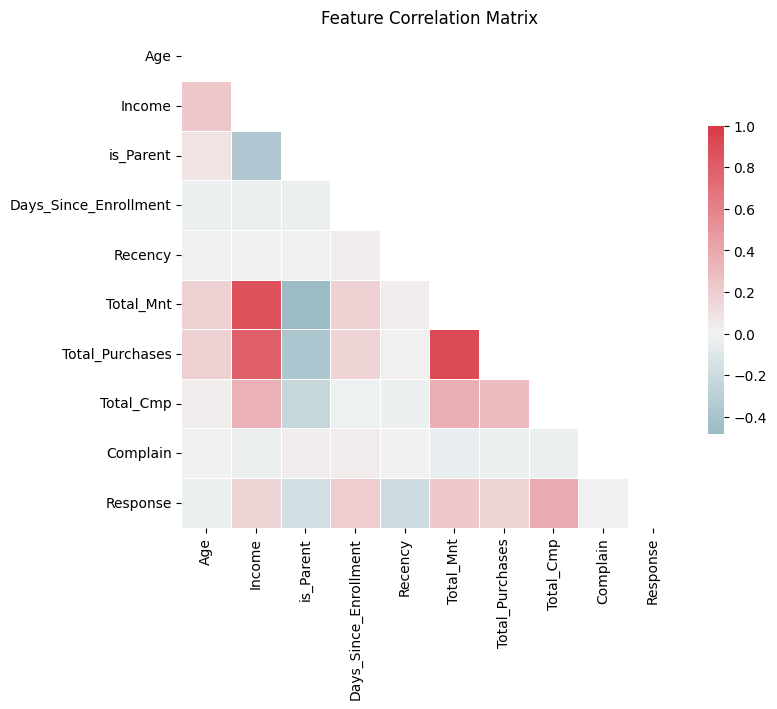

In [32]:
# Correlation Matrix
corr_matrix = custom_df.corr(method='spearman', numeric_only=True)  # Prima del ColumnTransformer
corr_mask = corr_matrix.mask(np.triu(np.ones_like(corr_matrix, dtype=bool)))

# Draw the heatmap with the mask and correct aspect ratio
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.subplots(figsize=(8,8))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix')
plt.show()

In [33]:
# Estrai coppie con correlazione assoluta > 0.8
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
high_corr = corr_pairs[(abs(corr_pairs) > 0.8) & (abs(corr_pairs) < 1)]

print(high_corr)

Total_Mnt        Total_Purchases    0.909015
Total_Purchases  Total_Mnt          0.909015
Income           Total_Mnt          0.868170
Total_Mnt        Income             0.868170
dtype: float64


**Total_Purchases and Total_Mnt**: These features are strongly correlated => highly informative.
**Another Insight**:It seems negative correlation hasn't high values.

In [34]:
#Check for pairs with correlation < -0.3
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
negative_corr = corr_pairs[((corr_pairs) < -0.3) & ((corr_pairs) > -1)]

print(negative_corr)

Income           is_Parent         -0.374449
is_Parent        Income            -0.374449
                 Total_Purchases   -0.383982
Total_Purchases  is_Parent         -0.383982
Total_Mnt        is_Parent         -0.480503
is_Parent        Total_Mnt         -0.480503
dtype: float64


Not so high correlation pairs but still relevant for the analysis.
Let's check if we can spot a feature to remove that has low correlation with response. 

In [35]:
#Check for pairs with correlation < 0.2
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
low_corr = corr_pairs[((corr_pairs) < 0.2) & ((corr_pairs) > -0.2)]

print(low_corr)


Total_Purchases  Age                      0.188357
Age              Total_Purchases          0.188357
                 Total_Mnt                0.175860
Total_Mnt        Age                      0.175860
                 Days_Since_Enrollment    0.173111
                                            ...   
Complain         Total_Mnt               -0.035744
Response         is_Parent               -0.171988
is_Parent        Response                -0.171988
Response         Recency                 -0.199926
Recency          Response                -0.199926
Length: 62, dtype: float64


In [36]:
print(corr_matrix["Age"].sort_values(ascending=False))


Age                      1.000000
Income                   0.226663
Total_Purchases          0.188357
Total_Mnt                0.175860
is_Parent                0.082648
Total_Cmp                0.029062
Recency                  0.014809
Complain                 0.000715
Days_Since_Enrollment   -0.013654
Response                -0.019181
Name: Age, dtype: float64


In [37]:
#Remove Complain and update the correlation matrix
print(corr_matrix["Complain"].sort_values(ascending=False))
custom_df.drop(['Complain'], axis=1, inplace=True)

corr_matrix = custom_df.corr(method='spearman', numeric_only=True)  

print(corr_matrix["Recency"].sort_values(ascending=False))

Complain                 1.000000
Days_Since_Enrollment    0.036016
is_Parent                0.030303
Recency                  0.005687
Age                      0.000715
Response                 0.000049
Total_Purchases         -0.023216
Total_Cmp               -0.024315
Income                  -0.027494
Total_Mnt               -0.035744
Name: Complain, dtype: float64
Recency                  1.000000
Days_Since_Enrollment    0.026414
Total_Mnt                0.022923
Age                      0.014809
Total_Purchases          0.014146
is_Parent                0.011747
Income                   0.010281
Total_Cmp               -0.014034
Response                -0.199926
Name: Recency, dtype: float64


**Recency** has almost no correlation with the other features. However,the only correlation |value| > 0.1 is with the target value **Response**. Due to the size of the dataset, it's worth leaving it in the dataset and see if it helps.

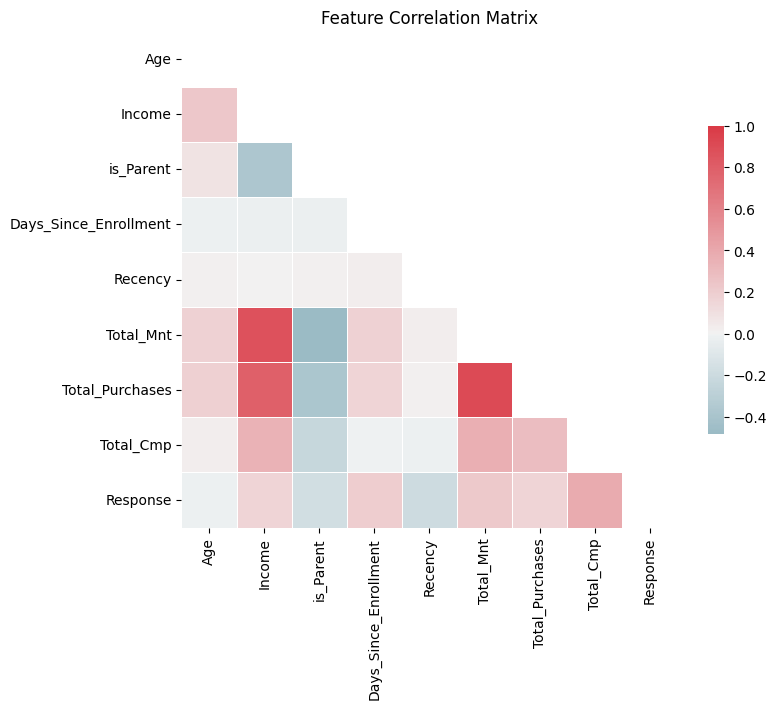

In [38]:

# Draw the heatmap to check one last time
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.subplots(figsize=(8,8))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix')
plt.show()

In [39]:
# Categorize columns into three groups based on their data type

binary_columns = [col for col in custom_df.columns if custom_df[col].nunique() == 2]
categorical_columns = [col for col in custom_df.columns if 2 < custom_df[col].nunique() < 10]
numerical_columns = [col for col in custom_df.select_dtypes(include=['number']).columns 
                     if col not in binary_columns + categorical_columns]

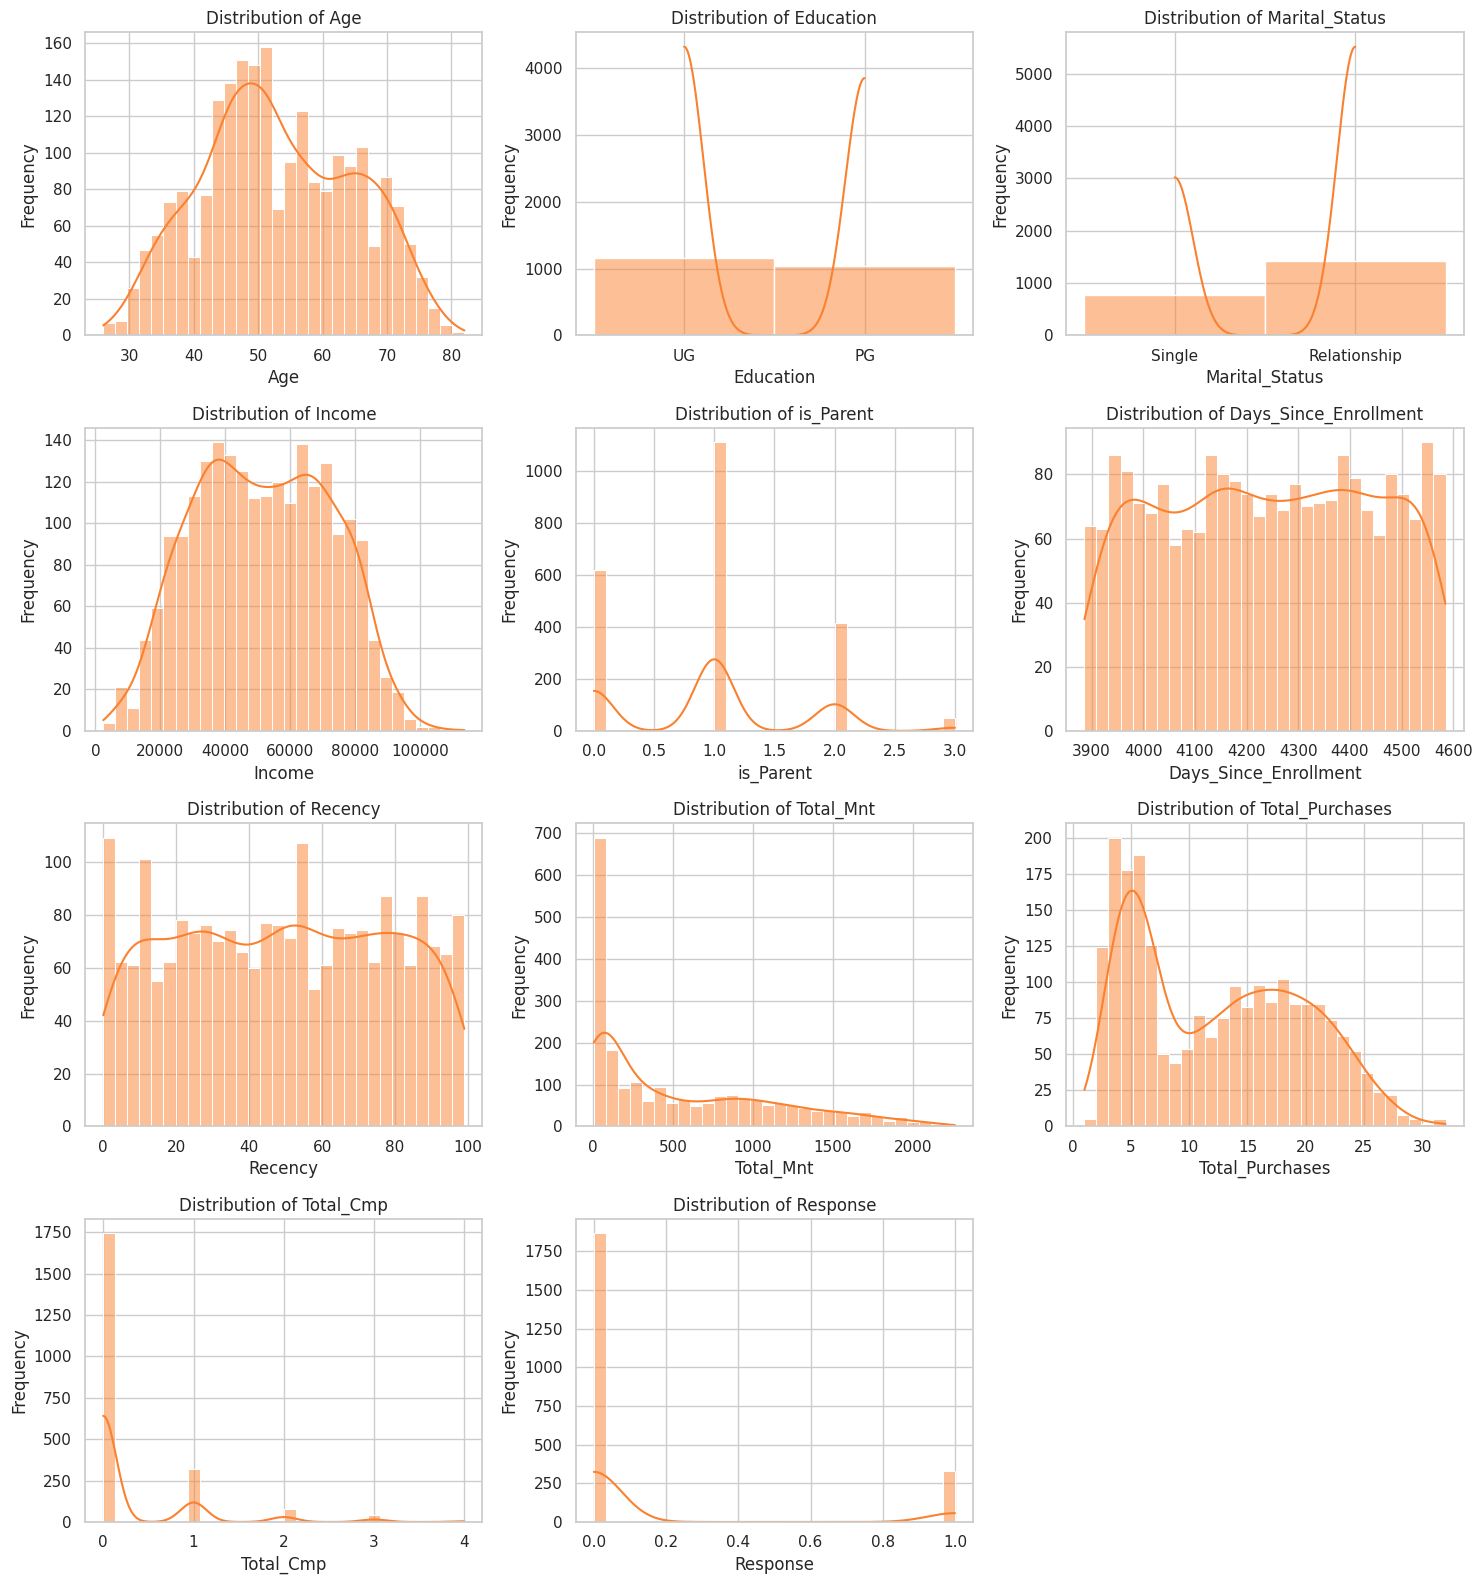

In [40]:
# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Define the color to be used for all plots
plot_color = '#FA812F'

# Create a figure with subplots
num_cols = len(custom_df.columns)
cols_per_row = 3  # Adjust this for the number of plots per row
num_rows = (num_cols // cols_per_row) + (num_cols % cols_per_row > 0)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 4))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through the columns and create a distplot for each
for i, column in enumerate(custom_df.columns):
    sns.histplot(df[column], kde=True, ax=axes[i], color=plot_color, bins=30)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if the number of columns is not a perfect multiple of cols_per_row
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Data Preprocessing (for Clustering)

In [41]:
# list of categorical columns
cat_df = list(df.select_dtypes(include=["object"]).columns)

# label encoding for the categorical columns
LE = LabelEncoder()
# encoding the categorical columns
for col in df:
    if df[col].dtype == 'object':
        df[col] = LE.fit_transform(df[col])

df.drop("Response", axis=1, inplace=True)

Define the features to be used in the clustering. We compute the median to prevent outliers, if any.

In [43]:
# Queste tre feature saranno utilizzate per il clustering
features = ['Days_Since_Enrollment', 'Income', 'Total_Mnt']
df_cluster = df[features].copy()

# Calcola le mediane globali (usate come soglie per interpretare i cluster)
median_enrollment      = df_cluster['Days_Since_Enrollment'].median()
median_income   = df_cluster['Income'].median()
median_total_mnt = df_cluster['Total_Mnt'].median()

print("Median Days since enrollment:", median_enrollment)
print("Median Income:", median_income)
print("Median Total_Mnt:", median_total_mnt)

# Standardizziamo le feature per garantire che tutte abbiano lo stesso peso nel clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

Median Days since enrollment: 4242.5
Median Income: 51277.0
Median Total_Mnt: 343.0


Let's define the segments of the clients we want to check. Here we will use **4 customer segments**:

**-Stars**: Old customers with high income and high spending nature.
**-Need Attention**: New customers with below-average income and low spending nature. 
**-High Potential**: New customers with high income and high spending nature.
**-Leaky Bucket**: Old customers with below-average income and a low spending nature.

# Clustering with KMeans

The K-Means is a greedy algorithm that clusters data by trying to separate samples in k groups of equal variance, minimizing a criterion known as the **inertia**, i.e. _within-cluster sum of squares_. It aims to choose centroids that minimize the inertia, which can be recognized as a measure of how **internally** coherent clusters are. We try to maximize the distance between the centroids.

Note: **k-means++** initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization.

In [44]:
# Applichiamo KMeans con 4 cluster
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
# Fittiamo il modello al dataset standardizzato
clusters = kmeans.fit_predict(X_scaled)
# Aggiungiamo la colonna 'Cluster' 
df_cluster['Cluster'] = clusters

# Calcoliamo i centroidi dei cluster riportandoli nella scala originale
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features)
print("\nCluster Centroids (Original Scale):\n", centroids_df)

# Dopo aver standardizzato le feature per garantire
# un corretto clustering, dobbiamo riportare i centroidi nella scala
# originale per capire cosa rappresentano in termini reali e poter
# assegnare etichette significative ai cluster.


Cluster Centroids (Original Scale):
    Days_Since_Enrollment        Income    Total_Mnt
0            4058.742188  38207.609375   111.435937
1            4423.799574  70930.505330  1248.153518
2            4404.325077  36702.386997   194.620743
3            4069.306122  72437.823129  1012.442177


Function to label a cluster based on the mean values of the centroid:

In [45]:
def label_segment(row):
    # Assegna "Old" se Enrollment >= mediana, altrimenti "New"
    enrollment_label = 'Old' if row['Days_Since_Enrollment'] >= median_enrollment else 'New'
    # Assegna "High" se sia Income che Total_Mnt sono sopra la mediana, altrimenti "Low"
    income_spending = 'High' if (row['Income'] >= median_income and row['Total_Mnt'] >= median_total_mnt) else 'Low'
    
    # Combina le due etichette per definire il segmento
    if enrollment_label == 'Old' and income_spending == 'High':
        return 'Stars'
    elif enrollment_label == 'New' and income_spending == 'High':
        return 'High Potential'
    elif enrollment_label == 'New' and income_spending == 'Low':
        return 'Need Attention'
    else:
        return 'Leaky Bucket'

Assign the segment to each cluster and map the label to the dataframe.

In [46]:
# Assegna il segmento ad ogni cluster in base al centroide
segment_labels = {cluster: label_segment(centroids_df.loc[cluster]) for cluster in centroids_df.index}
print("\nSegment Labels:", segment_labels)

# Mappa l'etichetta del cluster al DataFrame
df_cluster['Segment'] = df_cluster['Cluster'].map(segment_labels)

# Integra il risultato nel DataFrame originale
with open ("/work/df_complete.pkl", "rb") as f:
    df_complete = pickle.load(f)
df_complete = df_complete.loc[df.index]
df_complete['Segment'] = df_cluster['Segment']

# Visualizza la distribuzione dei segmenti
print("\nSegment Distribution:")
print(df_cluster['Segment'].value_counts())


Segment Labels: {0: 'Need Attention', 1: 'Stars', 2: 'Leaky Bucket', 3: 'High Potential'}

Segment Distribution:
Segment
Leaky Bucket      646
Need Attention    640
Stars             470
High Potential    440
Name: count, dtype: int64


Script to create 3D and 2D plots of the segments:

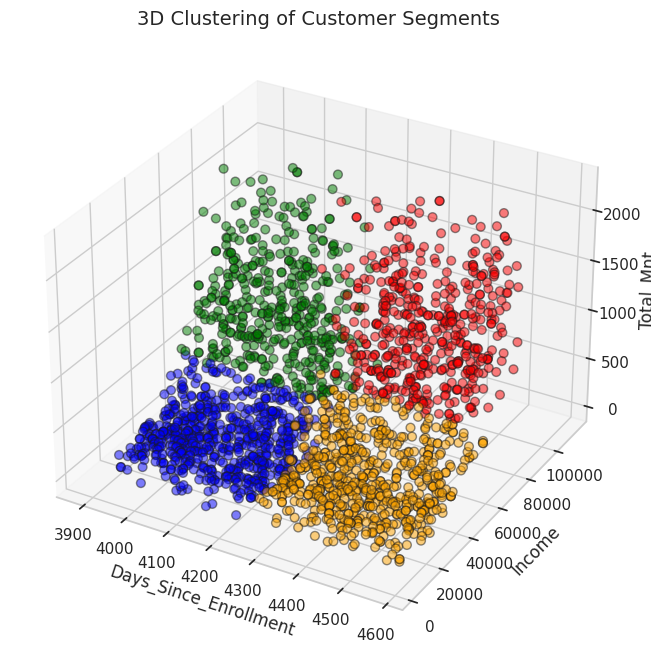

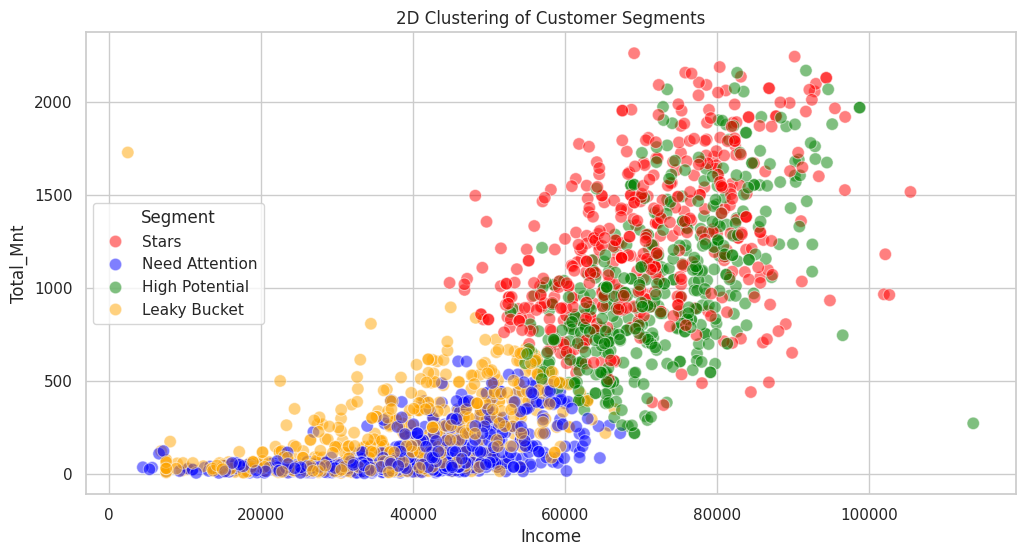

In [47]:
# Definiamo una mappa colori per una migliore visualizzazione
color_map = {
    'Stars': 'red',
    'High Potential': 'green',
    'Need Attention': 'blue',
    'Leaky Bucket': 'orange'
}
# Assegna i colori in base al segmento
colors = df_cluster['Segment'].map(color_map)

# Creiamo il plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_cluster['Days_Since_Enrollment'], df_cluster['Income'], df_cluster['Total_Mnt'],
           c=colors, s=40, alpha=0.5, edgecolor='k')
ax.set_xlabel('Days_Since_Enrollment', fontsize=12)
ax.set_ylabel('Income', fontsize=12)
ax.set_zlabel('Total_Mnt', fontsize=12)
ax.set_title('3D Clustering of Customer Segments', fontsize=14)
plt.show()

# Creiamo un plot 2D per una visualizzazione più semplice
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_cluster, x='Income', y='Total_Mnt', hue='Segment', palette=color_map, s=80, alpha=0.5)
plt.title('2D Clustering of Customer Segments')
plt.xlabel('Income')
plt.ylabel('Total_Mnt')
plt.legend(title='Segment')
plt.show()

## Analysis and Insights

The first graph represents a 3D clustering of customers based on Age, Income, and Total Mnt (Total Spending). Customers have been segmented into 4 groups:

- 🔴 **Stars** (Old customers with high income and high spending habits) → positioned in the upper region with high income and high spending.
- 🔵 **Need Attention** (New customers with below-average income and low spending habits) → concentrated in the lower part of the graph.
- 🟢 **High Potential** (New customers with high income and high spending habits) → spread towards the upper right, indicating high income and high spending.
- 🟡 **Leaky Bucket** (Old customers with below-average income and low spending habits) → located in the lower part, near the population with minimal spending.

**Key Insights**
- 🔴 The Stars segment consists of **long-term**, high-value customers who are likely **loyal** and should be retained.
- 🟡 The Leaky Bucket segment is at risk of leaving, requiring **re-engagement strategies**.
- 🟢 High Potential customers could become valuable long-term clients, making them a **prime target** for retention efforts.
- 🔵 The Need Attention segment is currently the least profitable but has potential for growth with the right incentives, considering it is formed of relatively _new customers_.

The second graph provides a 2D visualization (Income vs. Total Spending), making the clusters easier to interpret:
- 🔴 Stars and 🟢 High Potential dominate the upper segment, meaning they have high spending power and should be **prioritized**.
- 🔵 Leaky Bucket and 🟡 Need Attention remain in the lower section, indicating segments that **require strategic intervention**.

**Key Insights:**
Key Insights:

- Income is strongly correlated with spending, meaning **high-income customers should be prioritized** for loyalty programs.
- Leaky Bucket customers need targeted **promotions and discounts** to encourage them to continue purchasing.

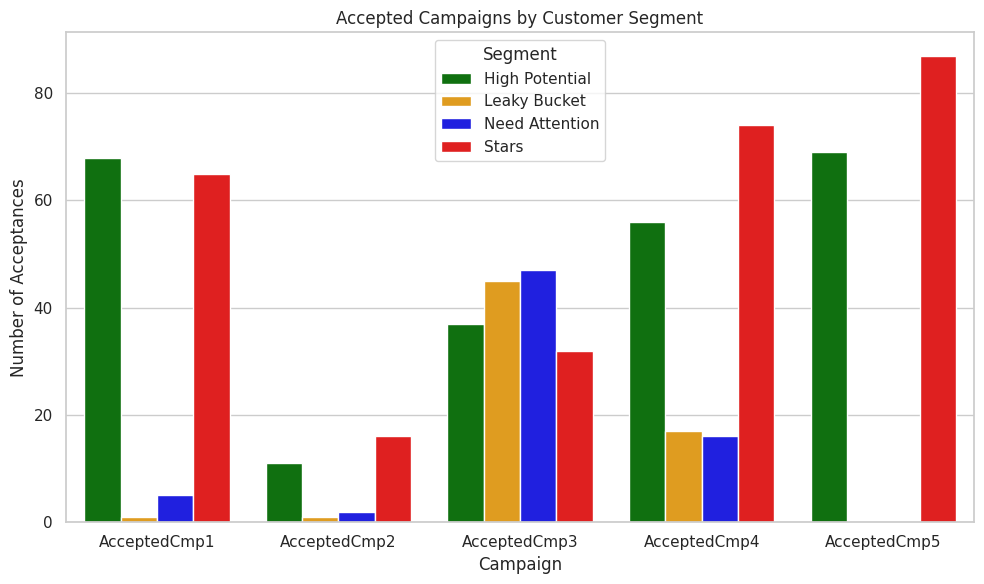

In [48]:
# Lista delle colonne delle campagne
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

# Creiamo un DataFrame in formato "lungo" (long format)
# In questo modo, per ogni campagna creiamo una riga per ogni cliente che ha accettato la campagna.
df_long = pd.DataFrame()

for campaign in campaign_cols:
    # Seleziona i clienti che hanno accettato la campagna (valore 1)
    accepted = df_complete[df_complete[campaign] == 1][['Segment']].copy()
    accepted['Campaign'] = campaign  # Aggiungiamo una colonna con il nome della campagna
    df_long = pd.concat([df_long, accepted], ignore_index=True)

# Raggruppiamo per campagna e segmento e contiamo il numero di occorrenze
grouped = df_long.groupby(['Campaign', 'Segment']).size().reset_index(name='Count')

# Plottiamo il grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x='Campaign', y='Count', hue='Segment', data=grouped, palette=color_map)
plt.title("Accepted Campaigns by Customer Segment")
plt.xlabel("Campaign")
plt.ylabel("Number of Acceptances")
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

In [37]:
# # Elenco delle 5 colonne dei prodotti
# product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts']

# # Raggruppa per Segment e somma gli importi spesi per ogni prodotto
# # Assumiamo che df_complete contenga la colonna 'Segment'
# df_segment = df_complete.groupby('Segment')[product_cols].sum()

# # Trasponiamo il DataFrame in modo che l'indice (x-axis) siano i prodotti e le colonne siano i segmenti
# df_segment = df_segment.T

# # Utilizziamo il plot built-in di Pandas per un grafico a barre raggruppate
# sns.barplot(x='Product', y='Total Amount Spent', hue='Segment', data=df_segment, palette=color_map)

# # Personalizziamo il grafico

# ax.set_title("Total Spending on 5 Products by Customer Segment", fontsize=14)
# ax.set_xlabel("Product", fontsize=12)
# ax.set_ylabel("Total Amount Spent", fontsize=12)
# plt.xticks(rotation=0)
# plt.legend(title="Segment", fontsize=10, title_fontsize=12)
# plt.tight_layout()
# plt.show()

KeyError: 'Segment'

In [40]:
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df_complete["is_Parent"],hue=df_complete["Segment"],palette= color_map)
pl.set_title("Count Of Kids at home")
pl.set_xlabel("Number Of Kids")
plt.show()

KeyError: 'Segment'

<Figure size 640x480 with 0 Axes>